In [31]:
# -*- coding: utf-8 -*-
"""SegNet model for Keras.
# Reference:
- [Segnet: A deep convolutional encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)
"""
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np

import matplotlib 
from matplotlib import pyplot as plt

import keras
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.applications import imagenet_utils

#####CLASS for Loss Curve
############################################################################################
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()
###########################################################################################
def preprocess_input(X):
    return imagenet_utils.preprocess_input(X)

def to_categorical(y, nb_classes):
    num_samples = len(y)
    Y = np_utils.to_categorical(y.flatten(), nb_classes)
    return Y.reshape((num_samples, int(y.size/num_samples), nb_classes))



Background = [0,0,0]
Polyp = [255,255,255]

label_colours = np.array([Background,Polyp])
def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,1):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb


#Function Definition for class visualization
def plot_results(output,X_test,y_test):
    n_test = X_test.shape[0]
    print (y_test.shape[0],'number of elements')
    plt.figure(figsize=(12, 2*n_test))
    
    for i in range(y_test.shape[0]):
        img = np.zeros((224,224,3))
        plt.subplot(n_test, 4, 4 * i + 1)#row col num
        plt.title('Input')
        plt.axis('off')

        img = X_test[:i+1]
        img = np.reshape(img,(224,224,3))
        print (img.shape,'shape of image')
        #plt.imshow(np.clip(gt, 0, 1))
        plt.imshow(img)
        
        plt.subplot(n_test, 4, 4 * i + 2)#row col num
        plt.title('Ground Truth')
        plt.axis('off')
        gt = y_test[:i]
        #plt.imshow(gt)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Prediction')
        plt.axis('off')

        
        labeled = np.argmax(output[i], axis=-1)
        labeled = np.reshape(labeled,(224,224))
        print (labeled.shape,'shape of labels')
        #argmax return the index of max value
        #if the pixel has large probability to be 1, the index will return 1(the index on the third dimension)
        plt.imshow(labeled)

        #plt.subplot(n_test, 4, 4 * i + 4)
        #plt.title('Heat map')
        #plt.axis('off')
		#plt.imshow(output[i][:, :, 1])

    plt.savefig('result.png')
    plt.show()

#(360, 480, 3)
#TRAINING Mode
#Input Shape of 224 x 224 like for VGG
input_shape = (224, 224, 3)
nb_classes = 2 #Binary Class Classification 0s for Background and 1s for the polyp
nb_epoch = 5#100
batch_size = 4
img_h = 224
img_w = 224
n_labels=2

#Definition of Segnet
#Define model
model = Sequential()

#Encoder Part
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Decoder Part
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(UpSampling2D(size=(2, 2),dim_ordering='default'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2, 2),dim_ordering='default'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2, 2),dim_ordering='default'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(nb_classes,(1,1),activation ='softmax'))


def SegNet(input_shape=(224, 224, 3), classes=2):
    # c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Conv2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Decoder
    x = Conv2D(512, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(classes, 1, 1, border_mode="valid")(x)
    x = Reshape((input_shape[0]*input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model

#LOAD DATA Here
#Quick Loading Data here:
X=np.load('training_images.npy')
#X=X[:2]
print (X.shape)
y=np.load('training_annotations.npy')
print (y.shape)
#y=y[:2]
#For all Ground Truth images available.
#normalise the labels
y= y/255
#y = np.reshape(y,(y.shape[0]*y.shape[1]*y.shape[2]*y.shape[3]))
print (y.shape,'size of preprocessed labels')
X_test=np.load('validation_images.npy')
#X_test =X_test[:2]
print (X_test.shape,'size of testing dataset')
y_test=np.load('validation_annotations.npy')
#y_test = y_test[:2]
print (y_test.shape,'size of testing labels')
y_test=y_test/255

#X, y = load_train() # need to implement, y shape is (None, 360, 480, nb_classes)
#X = preprocess_input(X)
Y = to_categorical(y, nb_classes=2)
Y_test = to_categorical(y_test,nb_classes=2)

model = SegNet(input_shape=input_shape, classes=nb_classes)
#TODO: modifications with different Optimizer Parameters. Adam Optimizers: 
#keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'adadelta', 'Adam', 'Adamax', 'Nadam']
#model.compile(loss="kullback_leibler_divergence", optimizer='adadelta', metrics=["accuracy"])
model.compile(loss="binary_crossentropy", optimizer='adadelta', metrics=["accuracy"])

total_score = model.fit(X, Y, validation_split=0.33, epochs=10, batch_size=10)
#total_score=model.fit(X, Y, batch_size=batch_size, nb_epoch=nb_epoch)#,callbacks=[plot_losses],verbose=0)






/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:166: UserWarning: Update your `UpSampling2D` call to the Keras 2 API: `UpSampling2D(data_format=None, size=(2, 2))`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:170: UserWarning: Update your `UpSampling2D` call to the Keras 2 API: `UpSampling2D(data_format=None, size=(2, 2))`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:174: UserWarning: Update your `UpSampling2D` call to the Keras 2 API: `UpSampling2D(data_format=None, size=(2, 2))`


(120, 224, 224, 3)
(120, 224, 224, 1)
(120, 224, 224, 1) size of preprocessed labels
(76, 224, 224, 3) size of testing dataset
(76, 224, 224, 1) size of testing labels


/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:186: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:191: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:196: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:201: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:206: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/home/oushesh/anaconda3/envs/tensorflow/l

Train on 80 samples, validate on 40 samples
Epoch 1/10
80/80 [==============================] - 198s 2s/step - loss: 0.7062 - acc: 0.6818 - val_loss: 1.5712 - val_acc: 0.2445
Epoch 2/10
80/80 [==============================] - 221s 3s/step - loss: 0.2832 - acc: 0.9525 - val_loss: 1.9375 - val_acc: 0.1738
Epoch 3/10
80/80 [==============================] - 221s 3s/step - loss: 0.2348 - acc: 0.9557 - val_loss: 1.8770 - val_acc: 0.2487
Epoch 4/10
80/80 [==============================] - 229s 3s/step - loss: 0.2161 - acc: 0.9559 - val_loss: 0.2739 - val_acc: 0.9530
Epoch 5/10
80/80 [==============================] - 234s 3s/step - loss: 0.2066 - acc: 0.9574 - val_loss: 0.3918 - val_acc: 0.9411
Epoch 6/10
80/80 [==============================] - 243s 3s/step - loss: 0.1877 - acc: 0.9575 - val_loss: 0.3043 - val_acc: 0.9460
Epoch 7/10
80/80 [==============================] - 234s 3s/step - loss: 0.1908 - acc: 0.9573 - val_loss: 0.3269 - val_acc: 0.9442
Epoch 8/10
80/80 [=====================

In [32]:
#Implementation of dice_coefficient
import keras.backend as K
smooth =1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#adadelta
#"kullback_leibler_divergence"
model.compile(optimizer='adadelta',loss=dice_coef_loss, metrics=[dice_coef])
dice_results = model.fit(X, Y, validation_split=0.33, epochs=10, batch_size=10)
#dice_results =model.fit(X, Y, batch_size=batch_size, nb_epoch=nb_epoch)

Train on 80 samples, validate on 40 samples
Epoch 1/10
80/80 [==============================] - 198s 2s/step - loss: -0.9025 - dice_coef: 0.9025 - val_loss: -0.6991 - val_dice_coef: 0.6991
Epoch 2/10
80/80 [==============================] - 217s 3s/step - loss: -0.9144 - dice_coef: 0.9144 - val_loss: -0.8004 - val_dice_coef: 0.8004
Epoch 3/10
80/80 [==============================] - 226s 3s/step - loss: -0.9140 - dice_coef: 0.9140 - val_loss: -0.8131 - val_dice_coef: 0.8131
Epoch 4/10
80/80 [==============================] - 225s 3s/step - loss: -0.9242 - dice_coef: 0.9242 - val_loss: -0.8387 - val_dice_coef: 0.8387
Epoch 5/10
80/80 [==============================] - 237s 3s/step - loss: -0.9282 - dice_coef: 0.9282 - val_loss: -0.8506 - val_dice_coef: 0.8506
Epoch 6/10
80/80 [==============================] - 233s 3s/step - loss: -0.9318 - dice_coef: 0.9318 - val_loss: -0.8637 - val_dice_coef: 0.8637
Epoch 7/10
80/80 [==============================] - 233s 3s/step - loss: -0.9346 - dic

dict_keys(['dice_coef', 'val_loss', 'val_dice_coef', 'loss'])


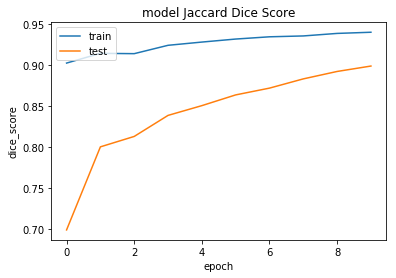

dict_keys(['dice_coef', 'val_loss', 'val_dice_coef', 'loss'])


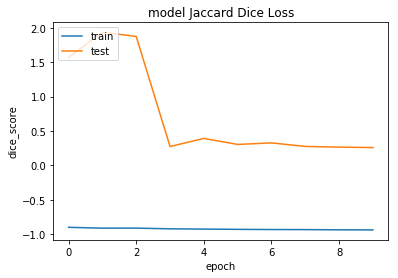

In [33]:
#Plotting
# list all data in model fit, total_score
print(dice_results.history.keys())

#Setting the plotting settings
# summarize history for accuracy
plt.plot(dice_results.history['dice_coef'])
plt.plot(dice_results.history['val_dice_coef'])
plt.title('model Jaccard Dice Score')
plt.ylabel('dice_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting
# list all data in model fit, total_score
print(dice_results.history.keys())
#Setting the plotting settings
# summarize history for accuracy
plt.plot(dice_results.history['loss'])
plt.plot(total_score.history['val_loss'])
plt.title('model Jaccard Dice Loss')
plt.ylabel('dice_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


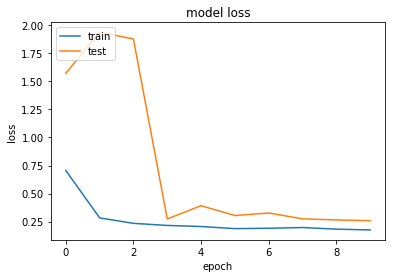

In [35]:
# summarize history for loss
plt.plot(total_score.history['loss'])
plt.plot(total_score.history['val_loss'])
#plt.plot(score.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

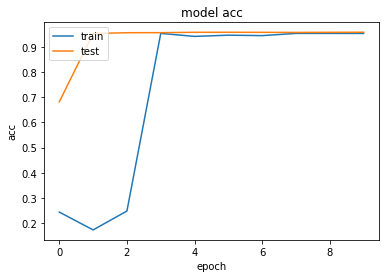

In [36]:
# summarize history for loss
plt.plot(total_score.history['val_acc'])
plt.plot(total_score.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(224, 224, 1)
(76, 224, 224, 1) size of testing labels
76/76 [==============================] - 52s 690ms/step
Test score: -0.89963361464
Test accuracy: 0.89963361464


NameError: name 'clf' is not defined

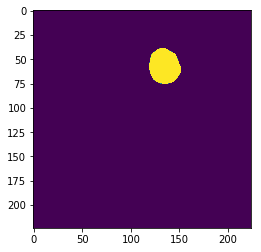

In [43]:
from keras.utils import np_utils

#Inference Part
#Print Ground Truth image
print (y_test[22].shape)
plt.imshow(np.reshape(y_test[22],(224,224)))

#Testing the model
#X_test=X[55,:]
#Y_test=Y[55,:]
X_test=np.load('validation_images.npy')
y_test=np.load('validation_annotations.npy')
#y_test = y_test[:2]
print (y_test.shape,'size of testing labels')
y_test=y_test/255
Y_test = to_categorical(y_test,nb_classes=2)
score = model.evaluate(X_test, Y_test, batch_size=1) #verbose=0)
print ('Test score:', score[0])
print ('Test accuracy:', score[1])

(76, 50176, 2) shape of prediction output
(76, 50176, 2) shape of output
(50176, 2) prediction on single image
(224, 224)


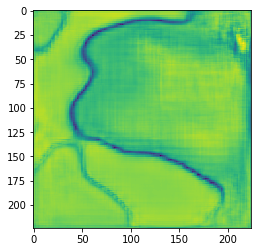

In [46]:
output = model.predict(X_test)


(76, 50176, 2) shape of all prediction output
(76, 50176, 2) shape of output
(50176, 2) prediction on single image
(224, 224)


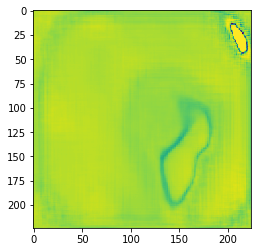

In [123]:

#Get the Prediction Map
print(output.shape,'shape of all prediction output')
#pred = visualize(np.argmax(output[22],axis=1).reshape((224,224)), False)
#plt.imshow(pred)

#print Prediction Map
print (output.shape,'shape of output')
print (output[40].shape, 'prediction on single image')
array=np.reshape(output[40],(224,224,2))
class_distribution = np.amax(array,axis=2)
print (class_distribution.shape)

plt.imshow(class_distribution)






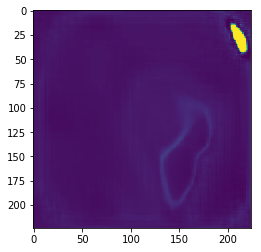

In [147]:
plt.imshow(array[:,:,1])#, cmap='binary',interpolation='nearest')
#plt.imshow(sample[:,:,0],cmap='binary',interpolation='nearest')